# Introduction
This notebook gives good practices that help when applying Vartiational Inference. We are going to use VI to regress a 1D function with a complex noise model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.autograd import Variable
import pyvarinf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import pylab as pl
%matplotlib inline

# GPU handling


In [2]:
use_cuda = torch.cuda.is_available()

# Building the model
The model used is a two layer MLP. The particularity here is that for every input $x$, the model outputs both a mean prediction $\mu(x)$ and a standard deviation $\sigma(x) = \log(1 + e^{\rho(x)})$. $\sigma$ is parameterized this way to avoid negative values.

In [3]:
n_units = 32

class Model(nn.Module):
    """ The model we are going to use """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU())
        self.mean = nn.Linear(n_units, 1)
        self.rho = nn.Linear(n_units, 1)
    
    def forward(self, *inputs):
        h = self.model(*inputs)
        return self.mean(h), self.rho(h)
    
model = Model()
var_model = pyvarinf.Variationalize(model)

if use_cuda:
    var_model = var_model.cuda()

# Generating dataset
We are attempting to fit a noisy function of the form
$$ y = \cos(3 x) + \mathcal{N}\left(0, 1\right) \frac{|x|}{2}. $$
Samples far from the origin are much noisier than samples close to it. Using the usual mean square error with a single output MLP is ill advised here, as it assumes a gaussian noise model with fixed variance.

Note that when you use the traditional mean square error, you usually assume that your probabilitic model is
$$ p(y\mid x) = \mathcal{N}\left(y\mid \mu=0, \sigma^2=1\right).$$
When using VI, to have a proper balance between the prior loss, which is a regularization term, and the Maximum likelihood term, you must select a $\sigma$ that makes sense for your data. If your data lie between $0$ and $0.01$, a model fitting the data with precision $\sigma=1$ is meaningless.

In [6]:
def generate_data(n_samples):
    """ Generate n_samples regression datapoints """
    x = np.random.normal(size=(n_samples, 1))
    y = np.cos(x * 3) + np.random.normal(size=(n_samples, 1)) * np.abs(x) / 2
    return x, y

def batch_iterator(x, y):
    """ Provides an iterator given data and labels """
    n_samples = x.shape[0]
    def _iterator(batch_size):
        sample_indices = np.random.randint(0, high=n_samples, size=batch_size)
        return x[sample_indices], y[sample_indices]
    return _iterator
    
n_train_data = 5000
n_test_data = 100
train_x, train_y = generate_data(n_train_data)
test_x, test_y = generate_data(n_test_data)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

[[-0.49386878]
 [ 0.77176928]
 [-0.24502895]
 ...
 [-1.12625283]
 [-0.82989252]
 [-1.14722845]]
[[-0.10269714]
 [-0.55293852]
 [ 0.62219589]
 ...
 [-0.55352134]
 [-0.68420504]
 [-1.69545101]]
(5000, 1) (5000, 1)
(100, 1) (100, 1)


# Normalize outputs
VI depends more on the prior/initialization than Maximum Likelihood Training. With Xavier initialization or He initialization, the order of magnitude of the outputs of the neural network is around 1 if the inputs are normalized. Setting the targets to remain close to that order of magnitude helps a lot.

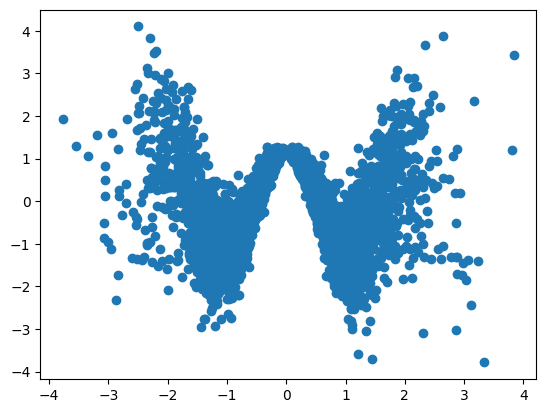

In [7]:
train_y = train_y / np.std(train_y)
test_y = test_y / np.std(test_y)

train_iterator = batch_iterator(train_x, train_y)
plt.scatter(train_x, train_y)

# Define plotting function

In [6]:
n_epochs = 300
n_samples = 4
def init_plot():
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-10, 10)
    ax1.set_xlabel("x", fontsize=20)
    ax1.set_ylabel("y", fontsize=20)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlim(0, n_epochs)
    ax2.set_ylim(-1.25, 1.25)
    ax2.set_xlabel("Epochs", fontsize=20)
    ax2.set_ylabel("Variational bound estimate", fontsize=20)

    lines = [ax1.plot(test_x, test_y, ls='', marker='o', alpha=0.7)]
    for _ in range(n_samples):
        lines += ax1.plot([0], [0], ls='', marker='o', alpha=0.3)
    loss_line, = ax2.plot([0.], [0.], alpha=0.7)
    prior_loss_line, = ax2.plot([0.], [0.], alpha=0.7)
    mle_loss_line, = ax2.plot([0.], [0.], alpha=0.7)
    ax2.legend([loss_line, prior_loss_line, mle_loss_line],
               ["Loss", "Prior loss", "MLE loss"])
    return lines, loss_line, prior_loss_line, mle_loss_line
    
def plot(lines, loss_line, prior_loss_line, mle_loss_line,
         epoch, loss, prior_loss, mle_loss):
    """ Plotting utility """
    # sample n models from the posterior
    if lines is None:
        lines, loss_line, prior_loss_line, mle_loss_line = init_plot()
    l0, lines = lines[0], lines[1:]
    n_samples = 10
    nets = [pyvarinf.Sample(var_model) for _ in range(n_samples)]
    for net in nets:
        net.draw()
    x_space = np.random.normal(size=(1000,))
    y_spaces = []
    for net in nets:
        inputs = Variable(torch.Tensor(np.expand_dims(x_space, 1)))
        noise = Variable(torch.randn(1000, 1))
        if use_cuda:
            noise = noise.cuda()
            inputs = inputs.cuda()
        mean, rho = net(inputs)
        outputs = mean + torch.log(1 + torch.exp(rho)) * noise
        y_spaces += [outputs.squeeze().data.cpu().numpy()]
    for l, y_space in zip(lines, y_spaces):
        l.set_data(x_space, y_space)
    lines = [l0] + lines
    
    epochs = loss_line.get_xdata()
    losses = loss_line.get_ydata()
    prior_losses = prior_loss_line.get_ydata()
    mle_losses = mle_loss_line.get_ydata()
    epochs = list(epochs) + [epoch]
    losses = list(losses) + [loss]
    prior_losses = list(prior_losses) + [prior_loss]
    mle_losses = list(mle_losses) + [mle_loss]
    loss_line.set_data(epochs, losses)
    prior_loss_line.set_data(epochs, prior_losses)
    mle_loss_line.set_data(epochs, mle_losses)
    return lines, loss_line, prior_loss_line, mle_loss_line
        

# Define log likelihood loss
We are learning both the mean and the variance of the noisy function we fit. The probabilistic model represented by our model is $p(y|x) = \mathcal{N}\left(y \mid \mu(x), \log(1 + e^{\rho(x)})^2\right)$. We must define the associated log likelihood.

In [7]:
def gaussian_fit_loss(data, mean, rho):
    """ Compute log likelihood of data, assuming 
    a N(mean, log(1 + e^rho)) model.
    """
    sigma = torch.log(1 + torch.exp(rho))
    return torch.mean( (mean - data) ** 2 / (2 * sigma ** 2) ) +  torch.mean(torch.log(sigma))


# Training
The model is trained as any other pytorch model, and we simply add the prior loss as a regularizer. The more data you have, the less you should regularize your model, which explains in a handwavy way why we divide the prior loss by the number of training examples. Have a look at the README for a more formal explaination.

VI is quite slow, due to the added randomness. You will still obtain a good fit in the end.

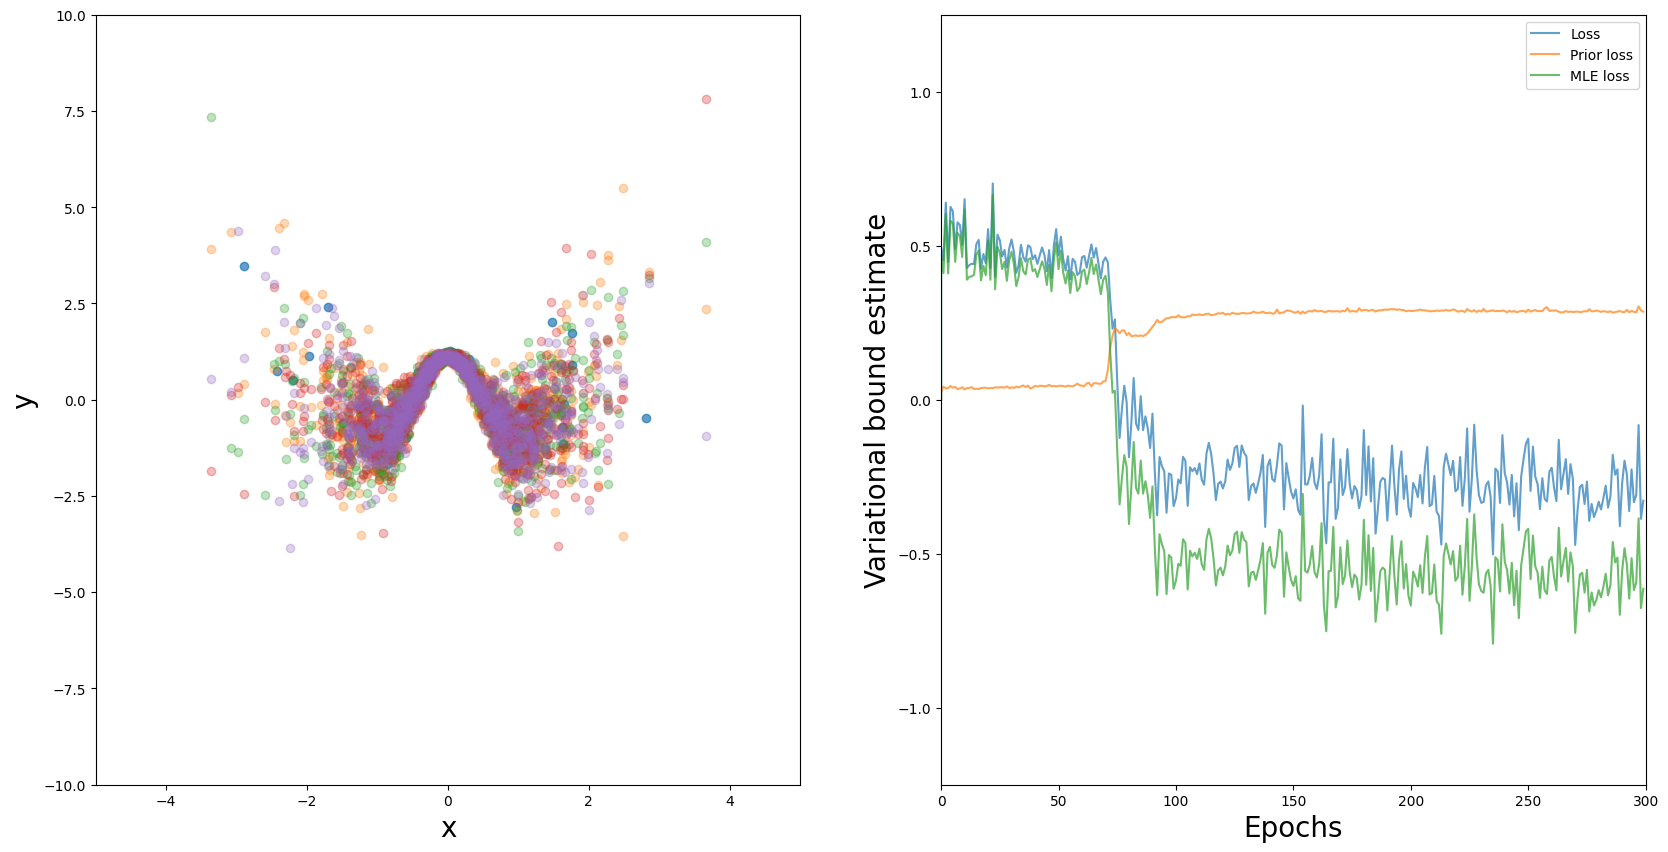

In [9]:
n_iterations_per_epochs = 100
batch_size = 256
mle_samples = 1

optimizer = torch.optim.Adam(var_model.parameters(), lr=5e-3)

lines = None
loss_line, prior_loss_line, mle_loss_line = None, None, None
for e in range(n_epochs):
    for i in range(n_iterations_per_epochs):
        batch_x, batch_y = train_iterator(batch_size)
        batch_x, batch_y = [Variable(torch.Tensor(arr)) for arr in [batch_x, batch_y]]
        if use_cuda:
            batch_x, batch_y = [arr.cuda() for arr in [batch_x, batch_y]]
        mle_loss = 0

        for _ in range(mle_samples):
            mean, rho = var_model(batch_x)
            mle_loss += gaussian_fit_loss(batch_y, mean, rho)

        mle_loss = mle_loss / mle_samples

        prior_loss = var_model.prior_loss() / n_train_data

        loss = mle_loss + prior_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    display.clear_output(wait=True)
    lines, loss_line, prior_loss_line, mle_loss_line = plot(
        lines, loss_line, prior_loss_line, mle_loss_line,
        e, loss.item(), prior_loss.item(), mle_loss.item())
    display.display(pl.gcf())

# Note
One could think that the use of our "complex" noise model is unnecessary here: VI introduces noise in the network, and this randomness could deal with the randomness of the function we have to fit. This is not the case. 

If we apply VI with a simple MSE loss on this task, we will obtain very good fits of the mean of the noisy function, but the model will ignore the function noise. 

To verify this fact, take the infinite data case. In this case, the network only suffers the MLE loss, and not the prior loss. The deterministic function that minimizes the mean square error is the mean of the noisy function. Thus, the mixture model that minimizes the mean square error on average is a mixture that only weights parameters that represent the mean of the noisy function (if you weight any other function, you will obtain a better average performance by reducing the weight on this function and readding an equivalent weight to the mean).